# PACKAGES

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import TensorFlow and its components
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


# Import scikit-learn functions for model evaluation and data manipulation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Import imbalanced data handling library
from imblearn.over_sampling import RandomOverSampler

# Import Keras utility for model loading
from keras.models import load_model

# Import OpenCV for image processing
import os


# Import Keras utility for one-hot encoding
from keras.utils import to_categorical
import cv2 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model


## DATA PREPROCESSING

In [2]:
def load_images_from_folder(folder, resize_dim=(256,256)):
    images = []
    image_extensions = [".jpg", ".jpeg", ".png"]  # Add more extensions if needed

    for filename in os.listdir(folder):
        file_ext = os.path.splitext(filename)[1].lower()
        if file_ext in image_extensions:
            img_path = os.path.join(folder, filename)
            # Load image using OpenCV
            img = cv2.imread(img_path)
            if img is not None:
                if resize_dim:
                    img = cv2.resize(img, resize_dim)
                images.append(img)
    return images

def display_sample_image(images, title):
    if images:
        print(f"Shape of the first image: {images[0].shape}")
        plt.figure(figsize=(10, 10), dpi=100)  # Increase figure size and DPI
        plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')  # Hide axes for a cleaner look
        plt.show()
    else:
        print(f"No images found in the folder for {title}.")

# Define folder paths for healthy, bean rust, and angular leaf spot images
healthy_folder = "healthy"
rust_folder = "bean_rust"
angular_folder = "als"


In [3]:
healthy_images = load_images_from_folder(healthy_folder)
rust_images = load_images_from_folder(rust_folder)
angular_images = load_images_from_folder(angular_folder)

# Print the number of images loaded for each category
print(f"Number of healthy images: {len(healthy_images)}")
print(f"Number of rust images: {len(rust_images)}")
print(f"Number of angular images: {len(angular_images)}")


Number of healthy images: 2642
Number of rust images: 2510
Number of angular images: 2549


Shape of the first image: (256, 256, 3)


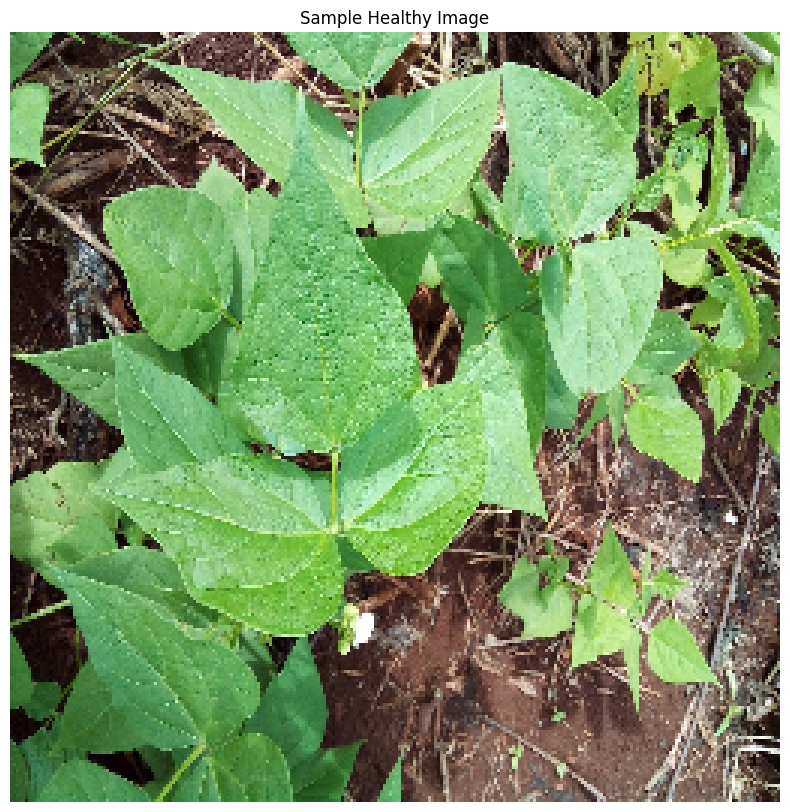

Shape of the first image: (256, 256, 3)


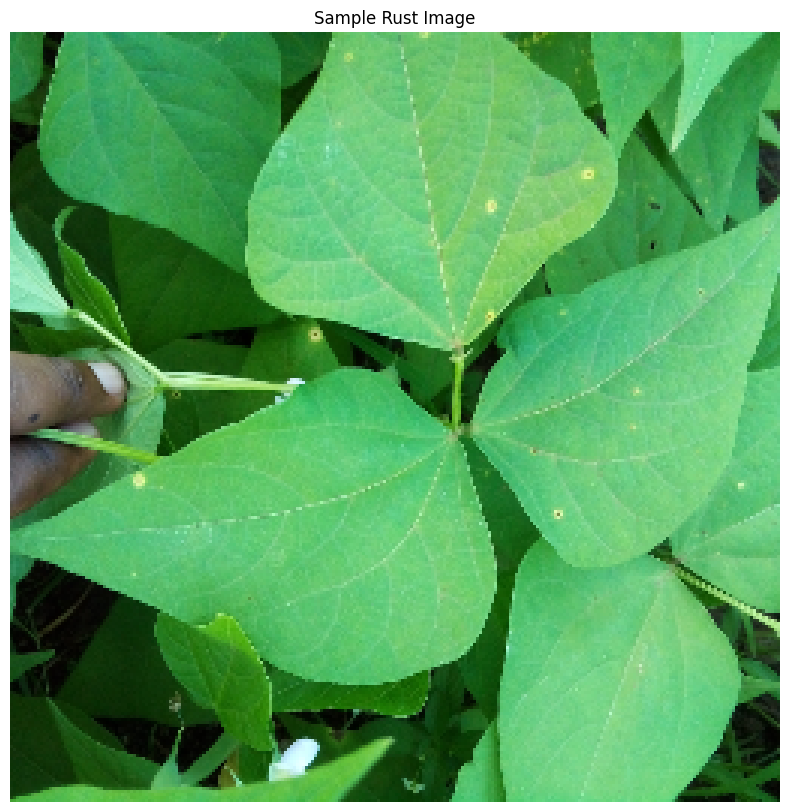

Shape of the first image: (256, 256, 3)


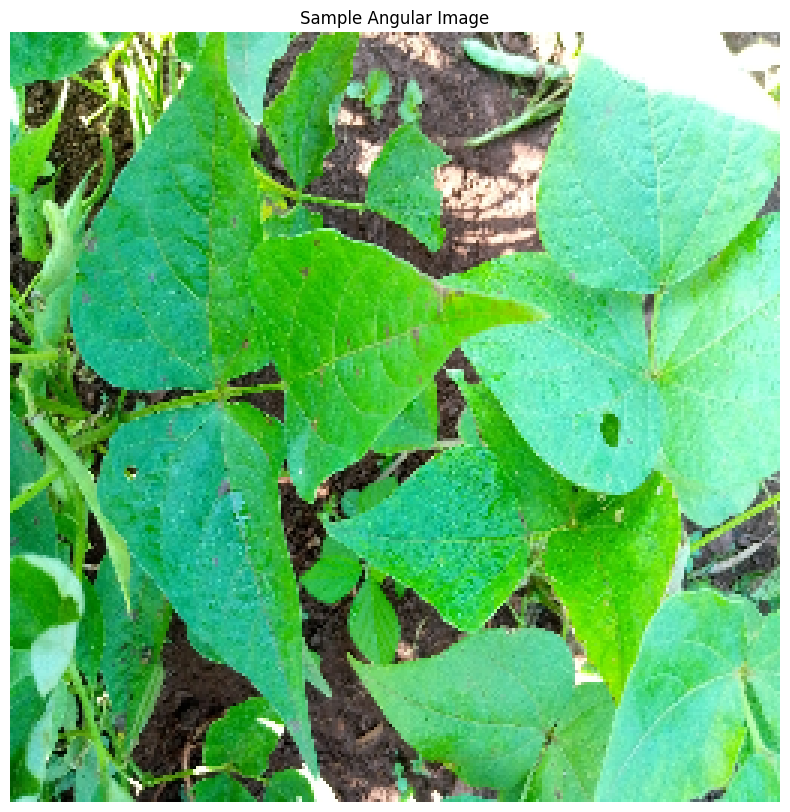

In [4]:
# Display sample images from each category
display_sample_image(healthy_images, "Sample Healthy Image")
display_sample_image(rust_images, "Sample Rust Image")
display_sample_image(angular_images, "Sample Angular Image")

In [5]:
# Combine original and augmented images
all_images = np.concatenate([healthy_images, rust_images, angular_images])

# Create corresponding labels for each image
labels = ['healthy'] * len(healthy_images) + ['rust'] * len(rust_images) + ['angular'] * len(angular_images)

# Calculate the number of classes
num_classes = len(np.unique(labels))

# Calculate the minimum test size required to ensure each class has at least one sample in the testing set
min_test_size = 1.0 / num_classes

test_s = 0.34  

print("Number of classes:", num_classes)
print("Test size:", test_s)

# Display the count of images per category
np.unique(labels, return_counts=True)

Number of classes: 3
Test size: 0.34


(array(['angular', 'healthy', 'rust'], dtype='<U7'),
 array([2549, 2642, 2510], dtype=int64))

In [6]:
# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert to one-hot encoding
labels_one_hot = to_categorical(labels_encoded)

# Normalize image data to the range [0, 1]
all_images_normalized = all_images.astype('float32') / 255.0

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    all_images_normalized, labels_one_hot, test_size=test_s, random_state=42, stratify=labels_encoded)

In [7]:
# Print the shape of training and testing sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (5082, 256, 256, 3), y_train shape: (5082, 3)
X_test shape: (2619, 256, 256, 3), y_test shape: (2619, 3)


In [8]:
cnn = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(0.001), input_shape=(256, 256, 3)),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    layers.Activation('relu'),
    Dropout(0.5),
    
    Dense(128, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    layers.Activation('relu'),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

# Compile the model with a lower learning rate
cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      2

In [9]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for the validation set, only rescaling
val_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_test, y_test, batch_size=32)

# Define early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

In [10]:
# Train the model
history = cnn.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
159/159 [==============================] - 351s 2s/step - loss: 1.8666 - accuracy: 0.5638 - val_loss: 1.9712 - val_accuracy: 0.3001 - lr: 1.0000e-04
Epoch 2/25
159/159 [==============================] - 334s 2s/step - loss: 1.6576 - accuracy: 0.6468 - val_loss: 2.2053 - val_accuracy: 0.3631 - lr: 1.0000e-04
Epoch 3/25
159/159 [==============================] - 329s 2s/step - loss: 1.5713 - accuracy: 0.6771 - val_loss: 1.8280 - val_accuracy: 0.5388 - lr: 1.0000e-04
Epoch 4/25
159/159 [==============================] - 322s 2s/step - loss: 1.4873 - accuracy: 0.7050 - val_loss: 1.3333 - val_accuracy: 0.7759 - lr: 1.0000e-04
Epoch 5/25
159/159 [==============================] - 317s 2s/step - loss: 1.4595 - accuracy: 0.7111 - val_loss: 2.3076 - val_accuracy: 0.5846 - lr: 1.0000e-04
Epoch 6/25
159/159 [==============================] - 305s 2s/step - loss: 1.4111 - accuracy: 0.7304 - val_loss: 1.5383 - val_accuracy: 0.7071 - lr: 1.0000e-04
Epoch 7/25
159/159 [====================

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn.evaluate(val_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

82/82 [==============================] - 39s 471ms/step - loss: 0.8527 - accuracy: 0.8404
Test accuracy: 0.8404


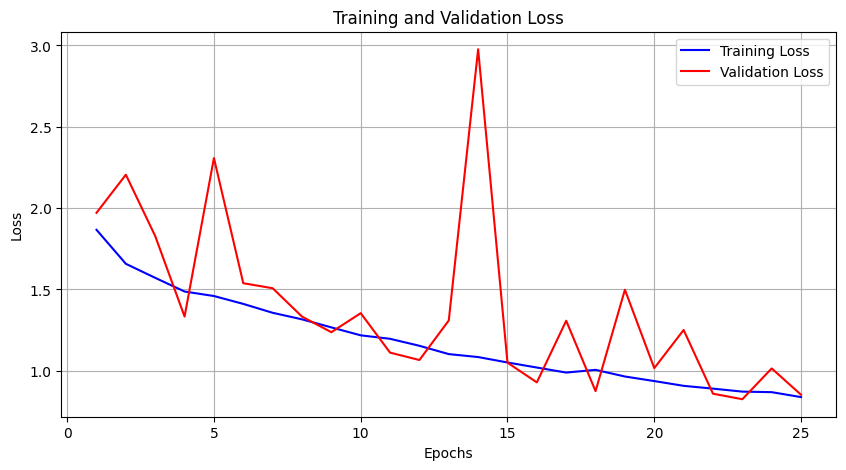

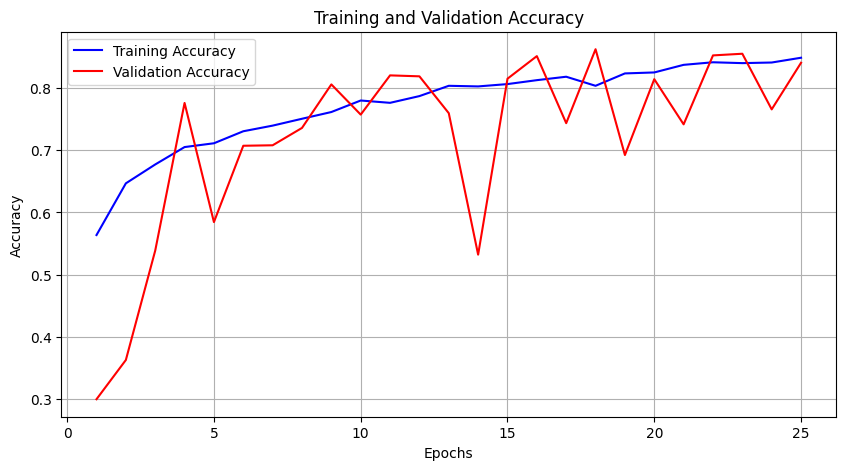

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Predict probabilities for the test set
y_pred_prob = cnn.predict(X_test)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)


82/82 [==============================] - 42s 509ms/step
Classification Report:
               precision    recall  f1-score   support

     angular       0.78      0.96      0.86       867
     healthy       0.85      0.99      0.91       898
        rust       0.95      0.57      0.71       854

    accuracy                           0.84      2619
   macro avg       0.86      0.84      0.83      2619
weighted avg       0.86      0.84      0.83      2619



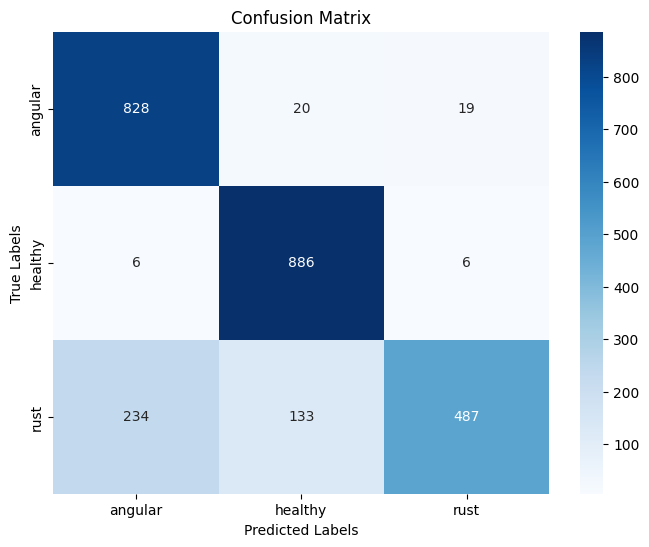

In [14]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [15]:
cnn.save('cnn.keras')

In [16]:
def create_modified_resnet_model(input_shape=(256, 256, 3), num_classes=3):
    # Load the pre-trained ResNet50 model without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Unfreeze the top layers of ResNet50
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add layers similar to the custom CNN
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create the model
resnet = create_modified_resnet_model(input_shape=(256, 256, 3), num_classes=num_classes)

# Print model summary
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [17]:
# Define early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# Train the ResNet model
history_resnet = resnet.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
159/159 [==============================] - 1906s 12s/step - loss: 1.1734 - accuracy: 0.7735 - val_loss: 4.9055 - val_accuracy: 0.3310 - lr: 1.0000e-04
Epoch 2/25
159/159 [==============================] - 1951s 12s/step - loss: 0.8294 - accuracy: 0.9317 - val_loss: 3.3260 - val_accuracy: 0.3310 - lr: 1.0000e-04
Epoch 3/25
159/159 [==============================] - 2032s 13s/step - loss: 0.7613 - accuracy: 0.9528 - val_loss: 2.4345 - val_accuracy: 0.3444 - lr: 1.0000e-04
Epoch 4/25
159/159 [==============================] - 2035s 13s/step - loss: 0.7298 - accuracy: 0.9595 - val_loss: 2.1368 - val_accuracy: 0.3448 - lr: 1.0000e-04
Epoch 5/25
159/159 [==============================] - 1758s 11s/step - loss: 0.6900 - accuracy: 0.9660 - val_loss: 1.1709 - val_accuracy: 0.7507 - lr: 1.0000e-04
Epoch 6/25
159/159 [==============================] - 1845s 12s/step - loss: 0.6539 - accuracy: 0.9734 - val_loss: 0.6975 - val_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 7/25
159/159 [========

In [18]:
# Evaluate the ResNet model on the test set
test_loss_resnet, test_accuracy_resnet = resnet.evaluate(val_generator)
print(f"ResNet Test accuracy: {test_accuracy_resnet:.4f}")

82/82 [==============================] - 184s 2s/step - loss: 0.3877 - accuracy: 0.9542
ResNet Test accuracy: 0.9542


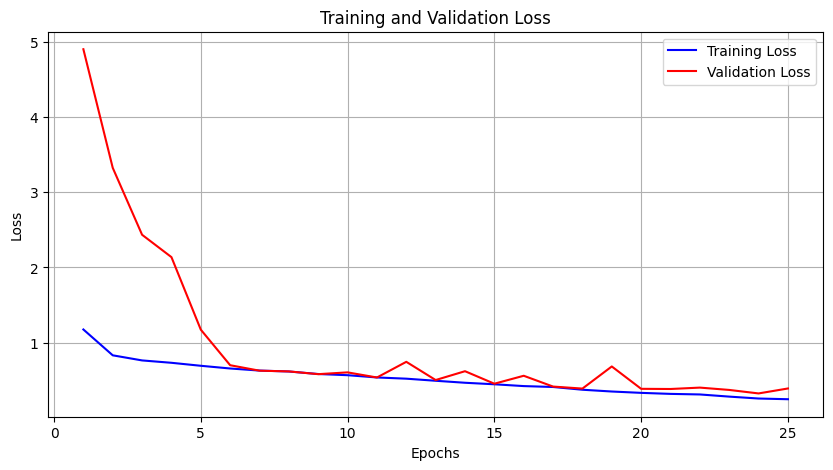

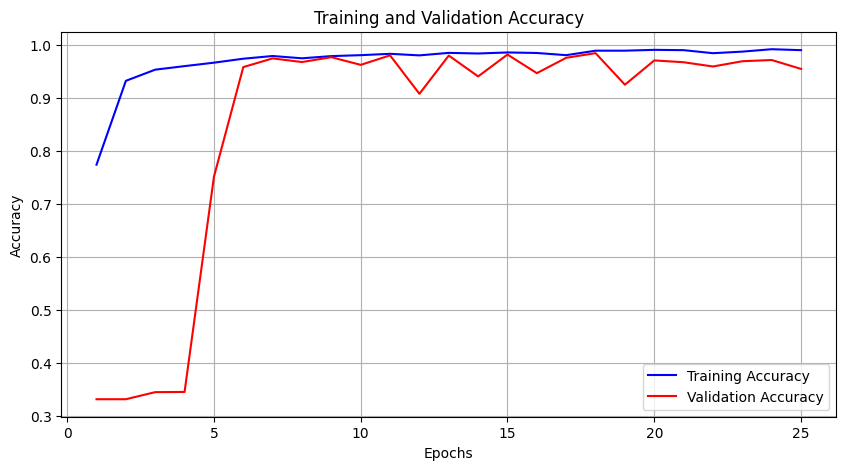

In [19]:
# Get training history
train_loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
train_accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



82/82 [==============================] - 187s 2s/step
Classification Report for ResNet:
               precision    recall  f1-score   support

     angular       0.93      0.98      0.96       867
     healthy       0.94      1.00      0.97       898
        rust       1.00      0.88      0.93       854

    accuracy                           0.95      2619
   macro avg       0.96      0.95      0.95      2619
weighted avg       0.96      0.95      0.95      2619



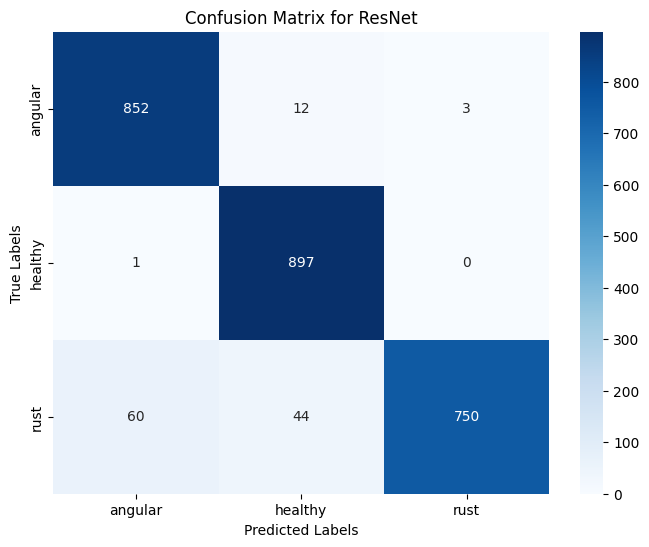

In [20]:
# Predict probabilities for the test set
y_pred_prob_resnet = resnet.predict(X_test)
# Convert probabilities to class labels
y_pred_resnet = np.argmax(y_pred_prob_resnet, axis=1)

# Generate classification report
report_resnet = classification_report(y_true, y_pred_resnet, target_names=label_encoder.classes_)
print("Classification Report for ResNet:\n", report_resnet)

# Compute confusion matrix
conf_matrix_resnet = confusion_matrix(y_true, y_pred_resnet)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for ResNet')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [21]:
resnet.save('resnet.keras')

In [23]:
results = {}
# Include ResNet in the comparison
results['ResNet'] = test_accuracy_resnet
results['CNN'] = test_accuracy
for name, accuracy in results.items():
    print(f'{name}: Accuracy = {accuracy:.4f}')



ResNet: Accuracy = 0.9542
CNN: Accuracy = 0.8404


In [24]:
results

{'ResNet': 0.9541809558868408, 'CNN': 0.8403971195220947}

['ResNet', 'CNN']
[0.9541809558868408, 0.8403971195220947]


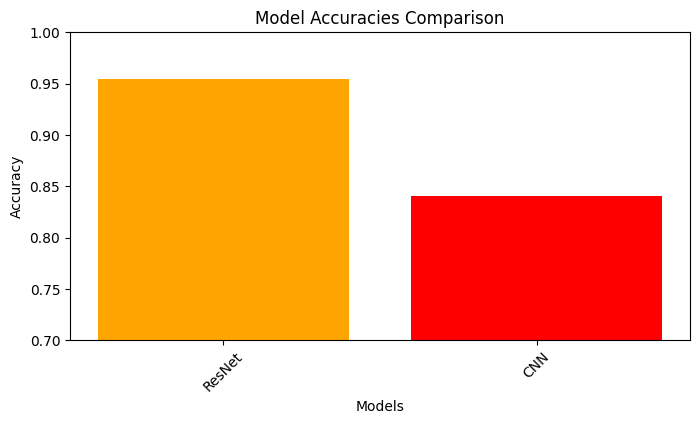

In [30]:
# Compare accuracies including ResNet
models_names = list(results.keys())
accuracies = list(results.values()) 
print (models_names)
print(accuracies)
plt.figure(figsize=(8, 4))
plt.bar(models_names, accuracies, color=['orange', 'red'])
plt.title('Model Accuracies Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1)
plt.xticks(rotation=45)
plt.show()